### Preamble

+ This notebook is modified notebooks originally developed and used in [Pankaj Mehta's ML for physics course](http://physics.bu.edu/~pankajm/PY580.html) at Boston University. Please check out those notebooks and associated textbooks for additional details and exercises.

+ Run the cells below to import the necessary libraries and set up the plotting environment.

In [18]:
## Preamble / required packages
import numpy as np
import scipy.sparse as sp
np.random.seed(0)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
# Comment this out to activate warnings
warnings.filterwarnings('ignore')


# Supervised learning

+ Given an input $X$, construct a function that assigns it a label $\hat{y}$. 

+ **Regression:** $\hat{y}$ is a continuous variable. For example, given a picture of a person, predict their age. In physics, a common example is to predict the energy of a particle given its momentum, or forecast the next step in a time series.

+ **Classification:** $\hat{y}$ is a discrete variable. For example, given a picture of an animal, predict whether it is a cat or a dog. In physics, a common example is to predict whether a phase is ordered or disordered, or to detect whether a signal point is a background, signal, or anomaly.

The function $\hat{y} = f_\theta(X)$ is learned from many instances of labelled data comprising $X \in \mathbb{N_{data} \times N_{features}}$ and known $y \in \mathbb{N_{data}}$ pairs. The "weights" or parameters $\theta$ are adjusted during *training*.



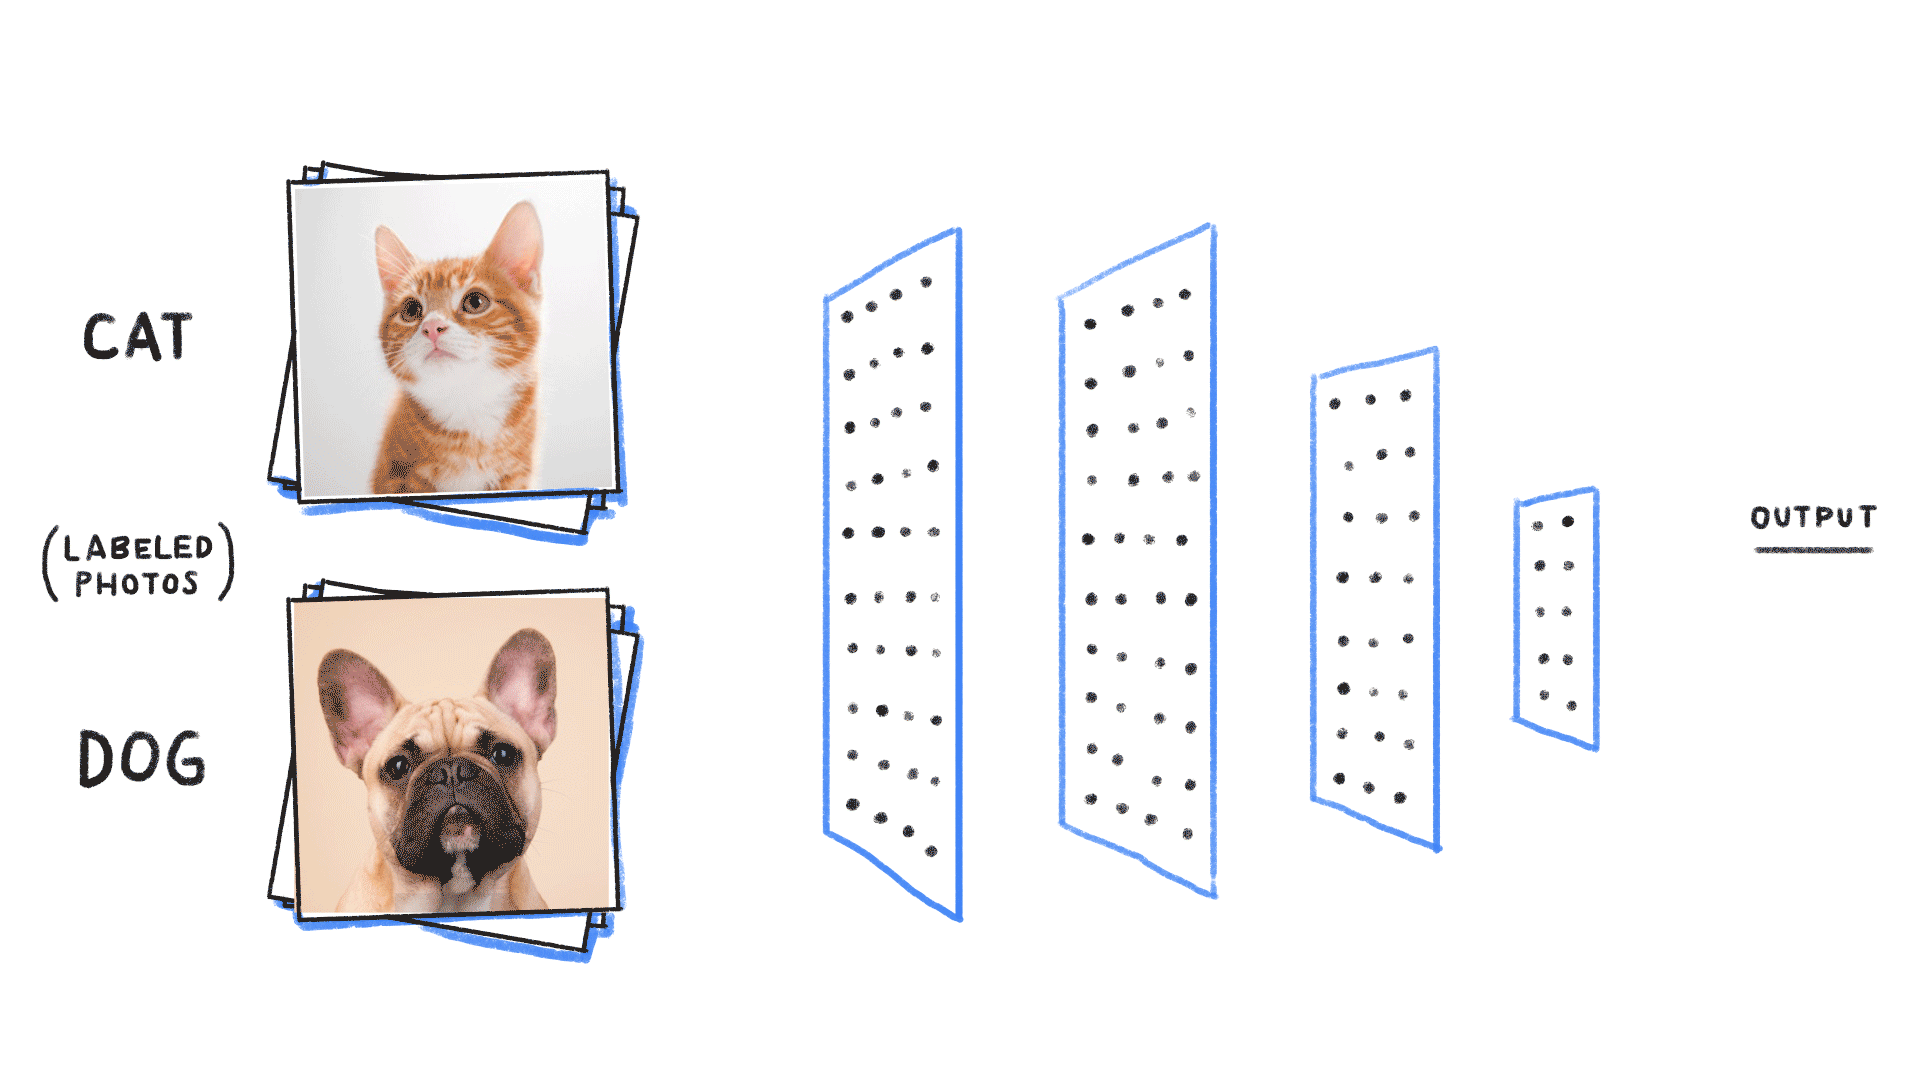

In [40]:
Image("../resources/supervised_learning.gif", width=750)
# https://github.com/ReiCHU31/Cat-Dog-Classification-Flask-App

## Supervised learning as inferring a generator

+ We can see supervised learning as the process of learning a *generator* for a dataset: given a set of points, can we approximate the underlying process that produced those points?
+ + Forecasting: given some past values, predict future values
+ + Regression: Given a known generator with unknonw parameters (like a quadratic Hamiltonian with unknown amplitudes), infer those amplitudes
+ + Classification (most famous example in ML): Given examples of labelled images, states, etc, predict the class of unlabelled data. We can think of the learned decision boundary as defining a generator of new examples belonging to that class (see conditional GANs, etc)

### Spin glasses

+ A spin glass has a Hamiltonian of the form

$$
H(\mathbf{s}^{(i)}) = - \sum_{jk} J_{jk} s_{j}^{(i)} \, s_{k}^{(i)}.
$$

where $s_{j}^{(i)} \in \{-1, 1\}$ is the spin of the $j^{th}$ spin in the $i^{th}$ experimental sample $\mathbf{s}^{(i)}$, and $J_{jk}$ is the interaction strength between the $j^{th}$ and $k^{th}$ spins. We assume that there are $L$ spins, and that the sum is over all $L(L-1)/2$ pairs of spins. 

+ In general, the coupling matrix is not symmetric $J_{jk} \neq J_{kj}$, and the diagonal elements are zero $J_{jj} = 0$ (no self-interactions)

+ Depending on the coupling matrix $J_{j,k}$, the system can be ferromagnetic, anti-ferromagnetic, or a spin glass. In a ferromagnet, all spins prefer to be aligned. In an anti-ferromagnet, all spins prefer to be anti-aligned. In a spin glass, there is no global preference for alignment or anti-alignment. Instead, the system is frustrated, and the spins cannot simultaneously minimize their energy.


### Experimental measurements of a spin glass

+ Suppose we have a spin glass with $L$ spins. We can prepare $N_{data}$ samples of the spin glass, and measure the energy $H(\mathbf{s})$ of each sample. 



### Load some experimental data

+ Our data consists of $N_{data}$ measurements of microstates $\mathbf{s}^{(i)}$, and their respective energies $E^{(i)}$.

In [4]:
microstates = np.load('../resources/spin_microstates.npy', allow_pickle=True)
energies = np.load('../resources/spin_energies.npy', allow_pickle=True)

print("Microstates shape: ", microstates.shape)
print("Energies shape: ", energies.shape)

Microstates shape:  (10000, 40)
Energies shape:  (10000,)


Text(0, 0.5, 'Number of microstates')

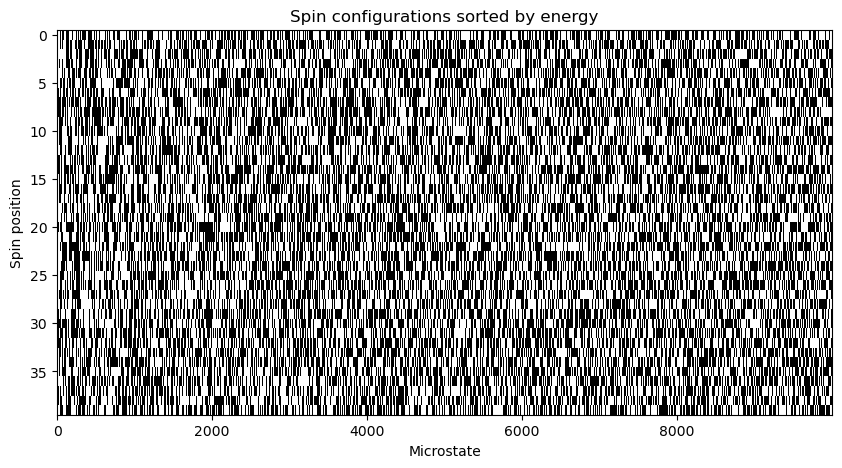

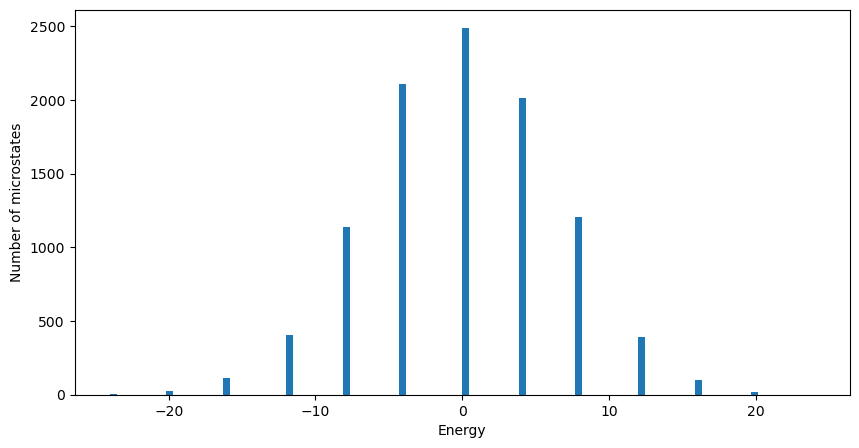

In [5]:


plt.figure(figsize=(10, 5))
plt.imshow(
    microstates[np.argsort(energies)].T, 
    interpolation='nearest', aspect='auto', cmap='binary'
)
plt.ylabel("Spin position")
plt.xlabel("Microstate")
plt.title("Spin configurations sorted by energy")
## aspect ratio
# plt.gca().set_aspect('auto')

plt.figure(figsize=(10, 5))
plt.hist(energies, bins=100)
plt.xlabel("Energy")
plt.ylabel("Number of microstates")


## Can we infer the unknown $J_{jk}$, given only the samples and their energies?


Our model class is defined as our known energy function for each sample,

$$
H(\mathbf{s}^{(i)}) = - \sum_{jk} J_{jk} s_{j}^{(i)} \, s_{k}^{(i)}.
$$

We can define the vector $\mathbf{X}^i$ with components

$$
\mathbf{X}^{(i)}_{jk} = s_j^{(i)} s_k^{(i)}.
$$

or, in vector notation,

$$
\mathbf{X}^{(i)} = \mathbf{s}^{(i)} \otimes \mathbf{s}^{(i)}.
$$

Then the energy of each sample is

$$
E^{(i)} = - \sum_{jk} J_{jk} \mathbf{X}^{(i)}_{jk}.
$$

Notice that we've exploited our prior knowledge of the physics of this problem in order to put the problem into a linear form. This represents a sort of *feature engineering* where we've used an *inductive bias* to make the problem easier to solve.


### A note on flattening

Notice that our Hamiltonian contains a double sum, which indexes into two matrices. Rather than keeping track of two indices, we can flatten the matrices into vectors, and use a single index. 

Flattening over features space is a common technique in machine learning, which we previously used in order to apply PCA to image data.


In [7]:
X_all = microstates[:, :, None] * microstates[:, None, :] # outer product creates neighbor matrix
print("X_all shape: ", X_all.shape)

# Data matrix / design matrix always has shape (n_samples, n_features)
X_all = np.reshape(X_all, (X_all.shape[0], -1)) 
print("X_all shape: ", X_all.shape)

# Match our labels
y_all = energies
print("y_all shape: ", y_all.shape)

X_all shape:  (10000, 40, 40)
X_all shape:  (10000, 1600)
y_all shape:  (10000,)


### Training and testing data

+ Rather than fitting our Hamiltonian model to all of the data, we will split the data into a training set and a test set. 

+ We will fit the model to the training set, and then evaluate the trained model on the test set. 

+ This is a common technique in machine learning, and is used to avoid overfitting.

In [35]:

# define subset of samples
n_samples = 400

# define train and test data sets
X_train, X_test = X_all[:n_samples], X_all[n_samples : 3 * n_samples // 2]
y_train, y_test = y_all[:n_samples], y_all[n_samples : 3 * n_samples // 2]

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape, "\n")

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (400, 1600)
y_train shape:  (400,) 

X_test shape:  (200, 1600)
y_test shape:  (200,)


# Fitting a linear model with least squares

+ Because our Hamiltonian is linear with respect to the *outer product* state matrices, we expect that linear regression is a good way to infer the coupling matrix $J_{jk}$.

+ Recall that the linear model is defined as

$$
\hat{y} = A \cdot \mathbf{x}
$$
where $A$ is a matrix, then $\mathbf{x}$ is a vector of features, and $\hat{y}$ is a vector of predictions.

+ In our case, the features are the outer product state matrices $\mathbf{X}^{(i)}$, and the predictions are the energies $E^{(i)}$. We can directly solve for the matrix $A$ using the least squares method:

$$
A = \left( \mathbf{X}^T \mathbf{X} \right)^{-1} \mathbf{X}^T \mathbf{y}
$$

Recall that we need to use the Moore-Penrose pseudoinverse because the matrix $\mathbf{X}^T \mathbf{X}$ is not square, and the pseudoinverse is the closest thing to an inverse that we can get.

### `scikit-learn` 

+ Rather than using numpy, we will use the Python machine learning library `scikit-learn` to perform the linear regression. 

+ `scikit-learn` uses a consistent API for both simple models, like linear regression, and more complex models, like neural networks.



In [44]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)

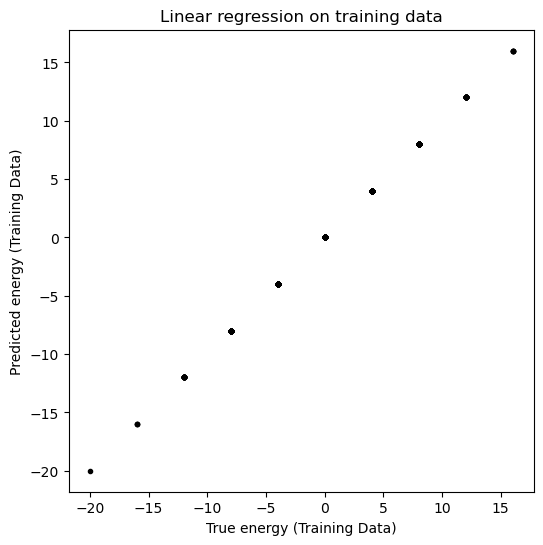

In [45]:
plt.figure(figsize=(6, 6))
plt.plot(y_train, y_pred_train, ".k")
plt.xlabel("True energy (Training Data)")
plt.ylabel("Predicted energy (Training Data)")
plt.title("Linear regression on training data")
plt.gca().set_aspect('auto')



What about experiments that the model hasn't seen before?

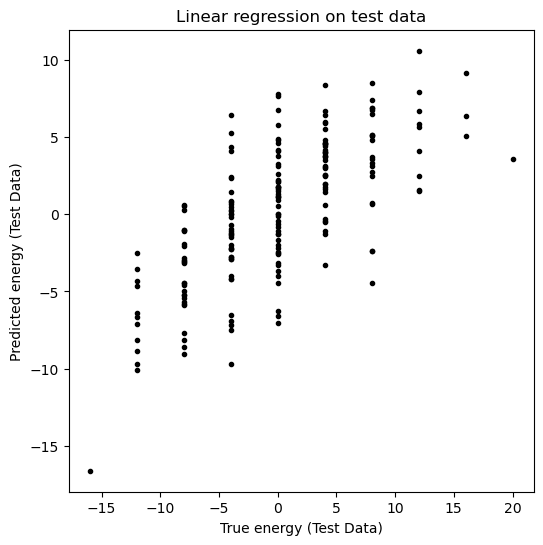

In [46]:
y_pred_test = model.predict(X_test)
# y_pred_test = model.predict(X_test)
plt.figure(figsize=(6, 6))
plt.plot(y_test, y_pred_test, ".k")
plt.xlabel("True energy (Test Data)")
plt.ylabel("Predicted energy (Test Data)")
plt.title("Linear regression on test data")
plt.gca().set_aspect('auto')

### Overfitting
+ High train accuracy just tells us that our model class is capable of expressing patterns found the training data
+ For all datasets, there exists a way to get 100% train accuracy as long as I have access to memory equal to the size of the training dataset (1-nearest-neighbor lookup table)
+ We therefore need to either regularize (training data can't be perfectly fit) or use a test dataset to see how good our model actually is
+ A reasonable heuristic when choosing model complexity is to find one that can just barely overfit train (suggests sufficient power)

# Evaluating the performance

### Regression scoring: the coefficient of determination $R^2$

In what follows the model performance (in-sample and out-of-sample) is evaluated using the so-called coefficient of determination, which is given by:
\begin{align}
R^2 &= \left(1-\frac{u}{v}\right),\\
u&=(y_{pred}-y_{true})^2\\
v&=(y_{true}-\langle y_{true}\rangle)^2
\end{align}

The best possible score is 1.0 but it can also be negative. A constant model that always predicts the expected value of $y$, $\langle y_{true}\rangle$, disregarding the input features, would get a $R^2$ score of 0.

In [14]:
print("Train error was:", model.score(X_train, y_train))
print("Test error was:", model.score(X_test, y_test))

Train error was: 1.0
Test error was: 0.49574373554401063


## But raw score doesn't tell the whole story

+ We can get a great fit, but our model might have a lot of free parameters
+ There might be multiple valid coupling matrices $J$ that explain the observed data
+ Our model might be predictive but not interpretable, or physical
+ We either need more data, better data (sample rarer states), or a better model


## Let's look at the learned coupling matrix

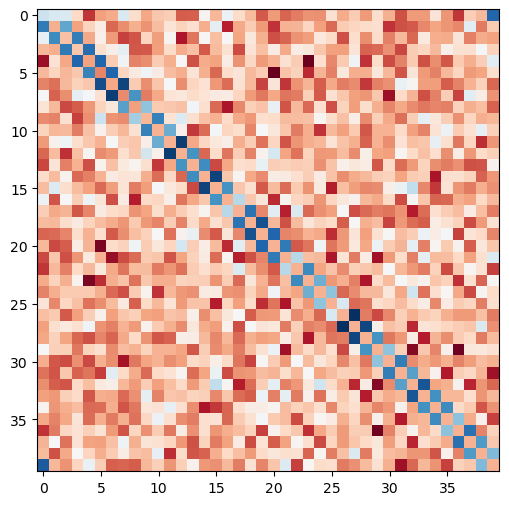

In [47]:
## Because we flattened the data, we need to reshape the coefficients to get the couplings
L = microstates.shape[1]
couplings_estimated = np.array(model.coef_).reshape((L, L))

plt.figure(figsize=(6, 6))
plt.imshow(couplings_estimated, cmap='RdBu_r')

## Let's try repeating the model fitting several times on different datasets

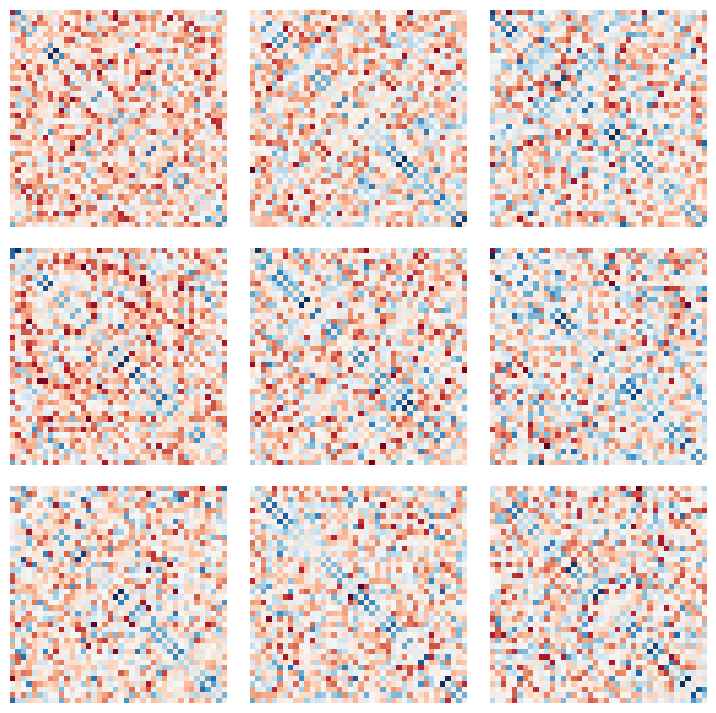

In [51]:


plt.figure(figsize=(9, 9))
## Plot 3 x 3 subplots

n_samples = 100
for i in range(9):

    ## Pick random training data set
    selection_inds = np.random.choice(range(X_all.shape[0]), size=n_samples, replace=False)
    X_train, y_train = X_all[selection_inds], y_all[selection_inds]
    model = LinearRegression()
    model.fit(X_all[selection_inds], y_all[selection_inds])
    couplings_estimated = np.array(model.coef_).reshape((L, L))
    
    ## Plot learned coupling matrix
    plt.subplot(3, 3, i + 1)
    plt.imshow(couplings_estimated, cmap='RdBu_r')
    plt.axis('off')

# spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)





    

# Narrowing the model class with regularization

+ We constrain the model's allowed space of valid representations in order to select for more parsimonious models

+ Operationally, regularizers/constraints reduce the "effective" number of parameters, and thus complexity, of our model

+ Imposing preferred basis functions or symmetries can be forms of regularization


### Ridge regression and Lasso:

+ We can think of our least-squares problem as choosing the optimal $J$ that minimizes the following objective function, the mean squared error between the model energies and true energies
$$
\mathcal{L} = \sum_{i=1}^{N_{data}} (\mathbf{X}^{(i)} \cdot \mathbf{J}- E^{(i)})^2
$$ 
+ where $i$ indicates different training examples, which have predicted energies given by $\mathbf{X}^i \cdot \mathbf{J}$ and observed energies of $H^i$

+ Common regularizers associated loss with the trainable parameters of the model. 

+ **Ridge regression** is also known as $L2$ regularization, and it discourages any particular weight in the coefficient matrix from becoming too large. Ridge imposes a degree of smoothness or regularity across how a model treats its various inputs. Models that take continuous data as inputs (such as time series, or images), may benefit from the ridge term.

+ + If $\mathbf{J}$ is our trainable linear regression weight matrix (and, in this context, our best estimate for the spin-spin interaction matrix), then we can modify the the losses as follows:
$$
\mathcal{L}_{Lasso} = \sum_{i=1}^{N_{data}} (\mathbf{X}^{(i)} \cdot \mathbf{J}- E^{(i)})^2 + \lambda \sum_{jk} | J_{jk} |
$$



+ **Lasso** is also known as $L1$ regularization, and it encourages *sparsity* in weight space: it incentivizes models were most coefficients go to zero, thereby reducing the models dependencies on features. Lasso is often used in feature selection, where we want to identify the most important features in a dataset.

$$
\mathcal{L}_{Ridge} = \sum_{i=1}^{N_{data}} (\mathbf{X}^{(i)} \cdot \mathbf{J}- E^{(i)})^2 + \lambda \sum_{jk} J_{jk}^2
$$
where the hyperparameter $\lambda$ determines the "strength" of the penalty terms.



Let's try re-fitting the model with these different regularizers. We will vary $\lambda$, the strength of the regularization, and see how the learned coupling matrix changes.

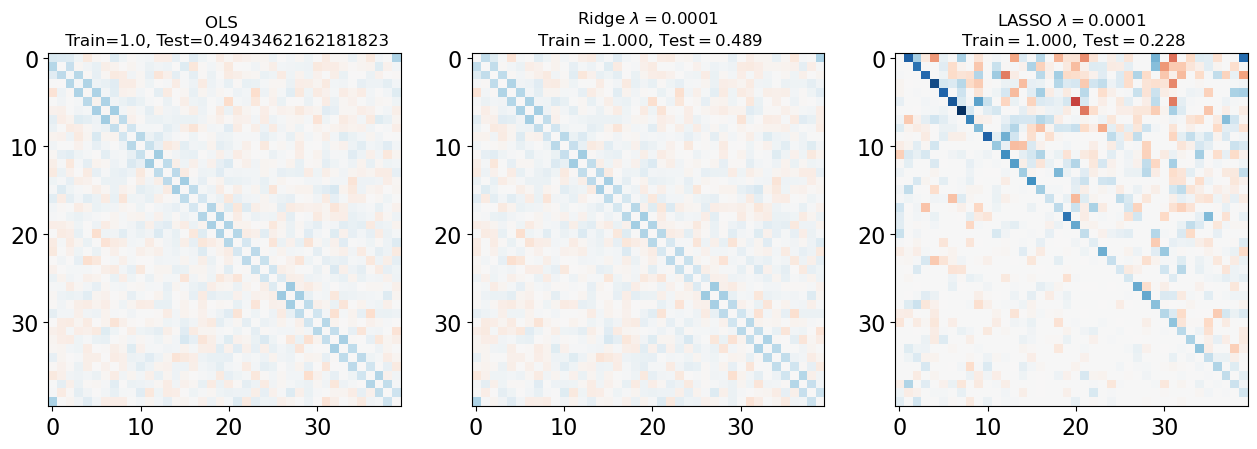

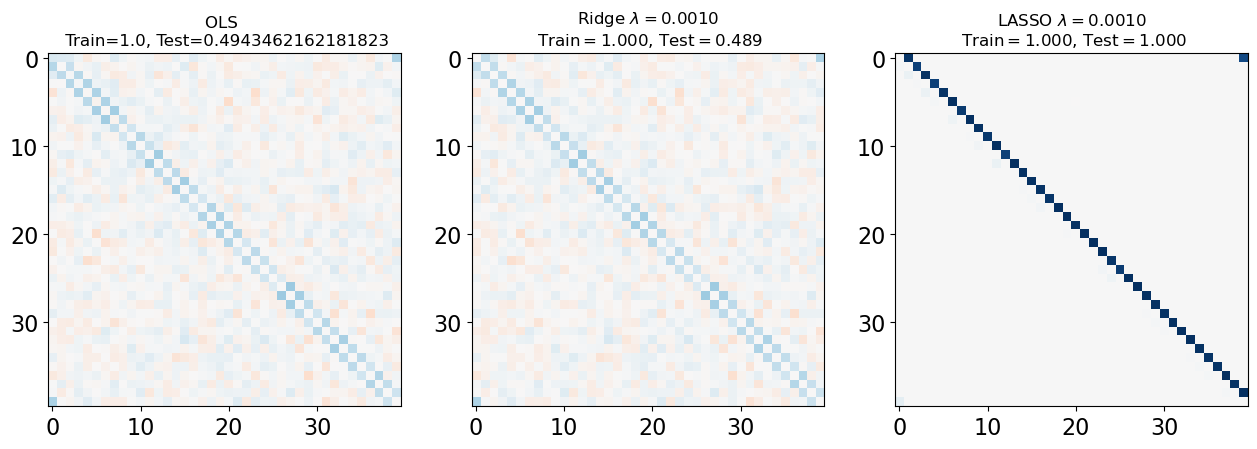

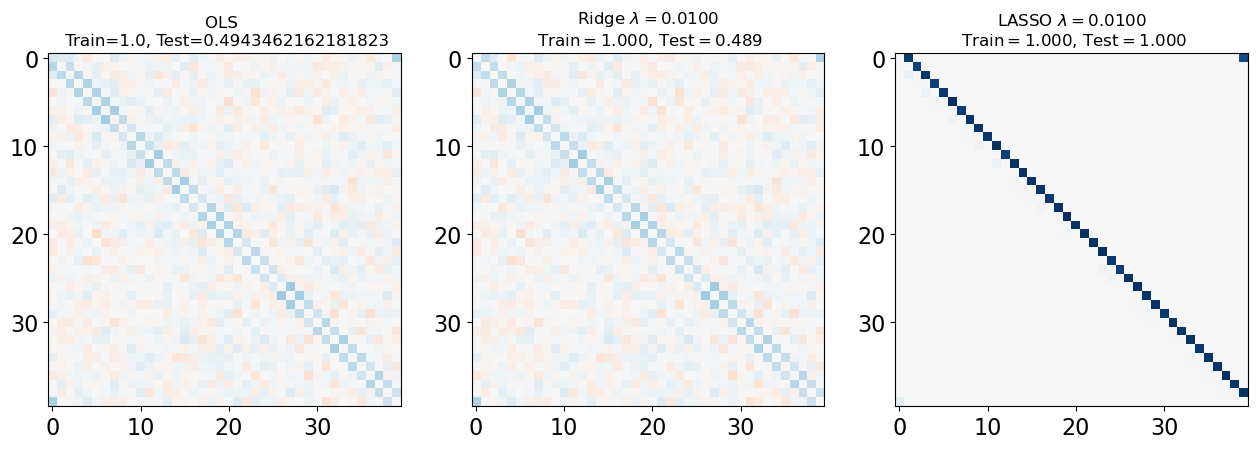

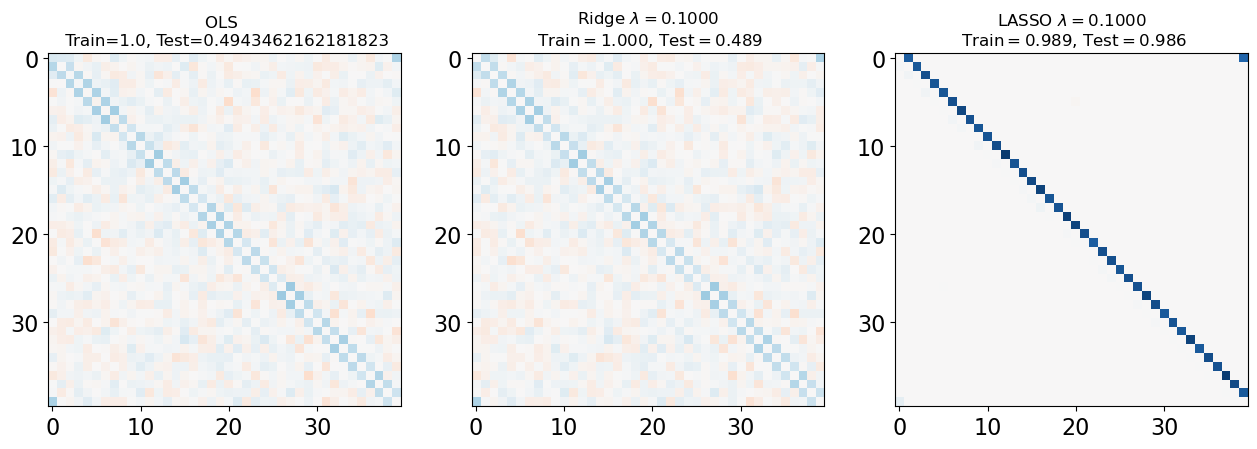

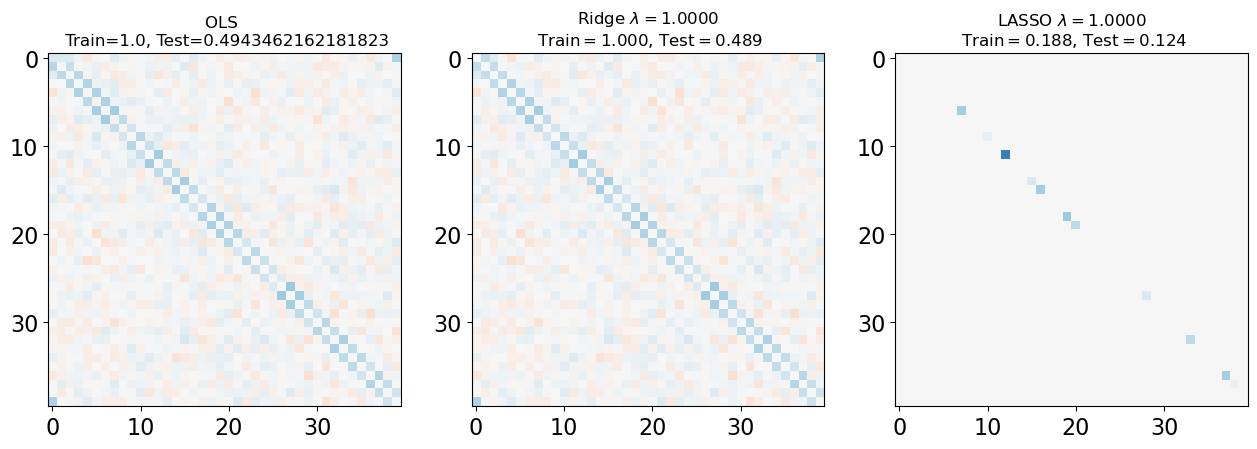

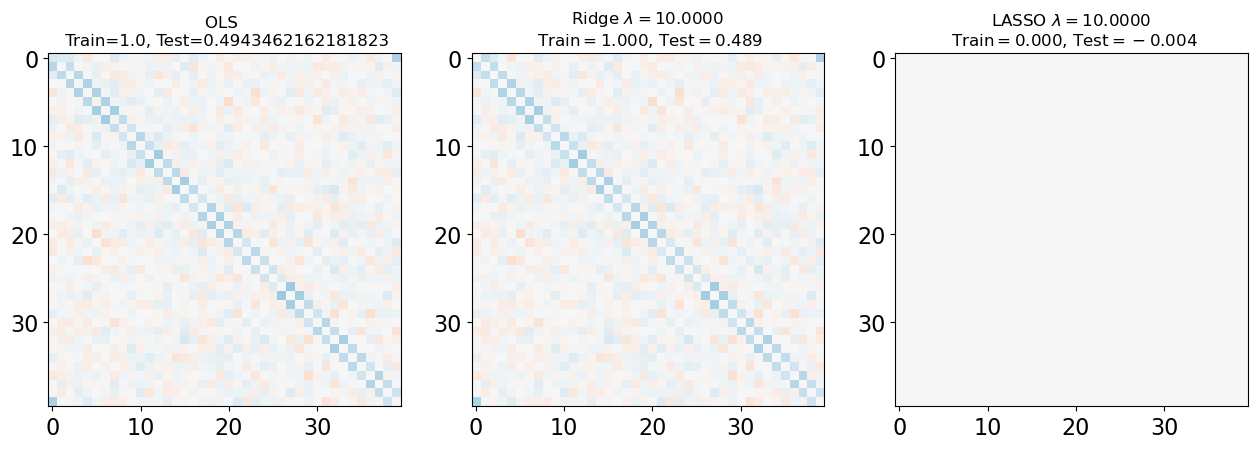

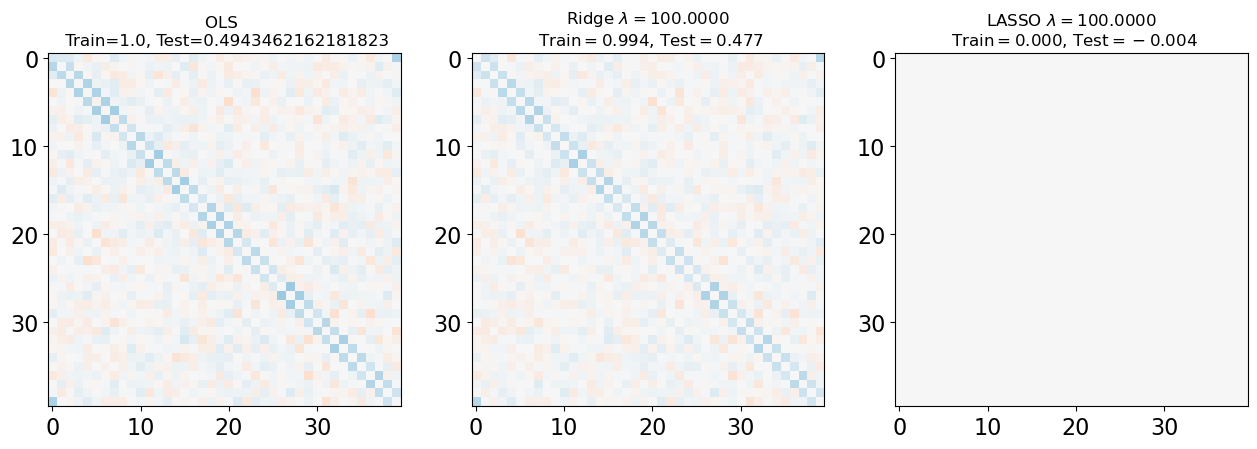

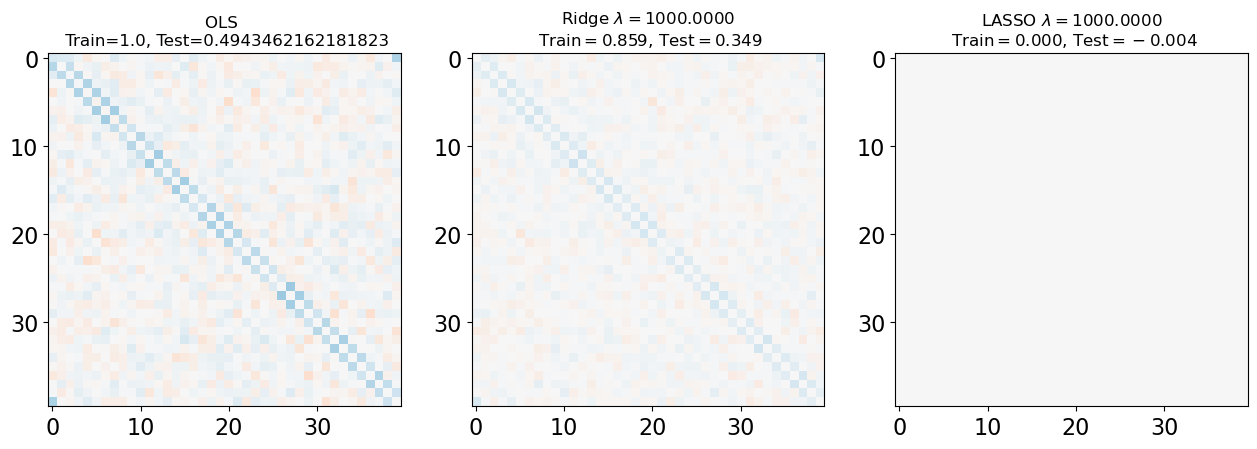

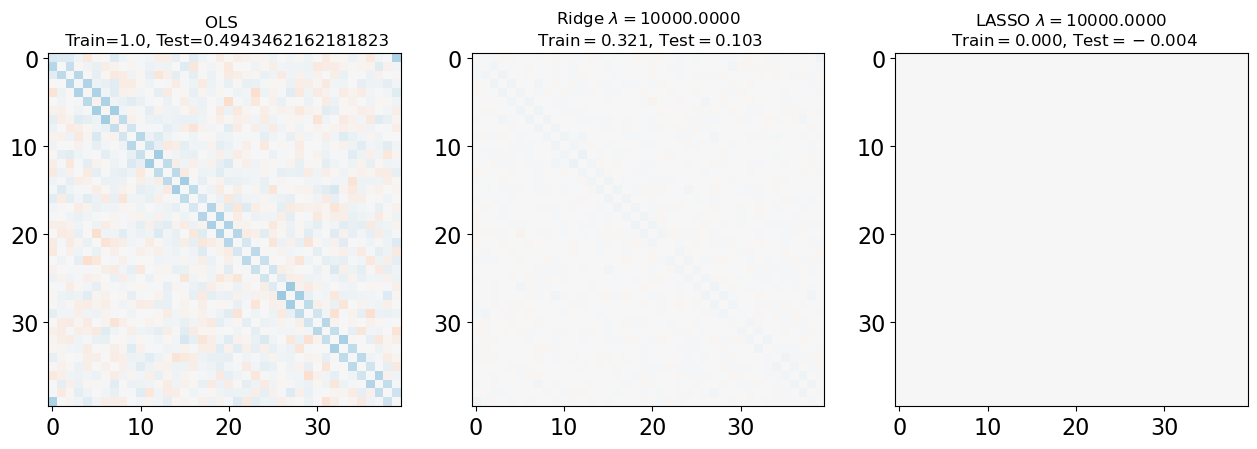

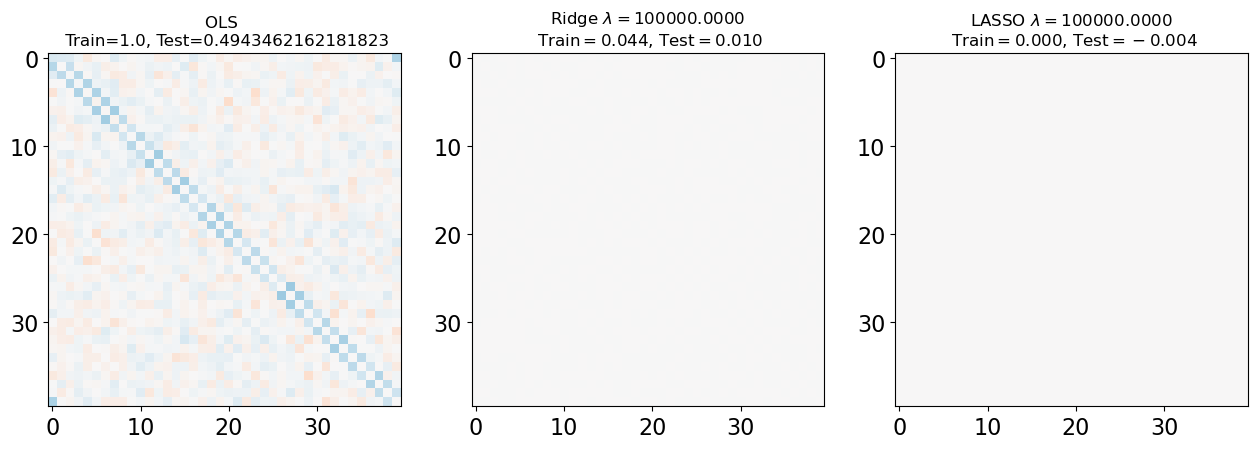

In [61]:


# Instantiate models
from sklearn import linear_model
model_ols = linear_model.LinearRegression()
model_l2 = linear_model.Ridge()
model_l1= linear_model.Lasso()

# Set regularization range
lambdas = np.logspace(-4, 5, 10)

# Load data
# define subset of samples
n_samples = 400
X_train, X_test = X_all[:n_samples], X_all[n_samples : 3 * n_samples // 2]
y_train, y_test = y_all[:n_samples], y_all[n_samples : 3 * n_samples // 2]

# define error lists
train_error_ols, test_error_ols = list(), list()
train_error_l2, test_error_l2 = list(), list()
train_error_l1, test_error_l1 = list(), list()

#Initialize coefficients for ridge regression and Lasso
coeffs_ols, coeffs_ridge, coeffs_lasso = list(), list(), list()

for lam in lambdas:
    ### ordinary least squares
    model_ols.fit(X_train, y_train) # fit model 
    coeffs_ols.append(model_ols.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_error_ols.append(model_ols.score(X_train, y_train))
    test_error_ols.append(model_ols.score(X_test, y_test))

    ### ridge regression
    model_l2.set_params(alpha=lam) # set regularisation strength
    model_l2.fit(X_train, y_train) # fit model
    coeffs_ridge.append(model_l2.coef_) # store weights
    train_error_l2.append(model_l2.score(X_train, y_train))
    test_error_l2.append(model_l2.score(X_test, y_test))

    ### lasso
    model_l1.set_params(alpha=lam) # set regularisation strength
    model_l1.fit(X_train, y_train) # fit model
    coeffs_lasso.append(model_l1.coef_) # store weights
    train_error_l1.append(model_l1.score(X_train, y_train))
    test_error_l1.append(model_l1.score(X_test, y_test))




    ### plot Ising interaction J
    J_leastsq = np.array(model_ols.coef_).reshape((L, L))
    J_ridge = np.array(model_l2.coef_).reshape((L, L))
    J_lasso = np.array(model_l1.coef_).reshape((L, L))


    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    axarr[0].imshow(J_leastsq,  cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[0].set_title(f"OLS \n Train={train_error_ols[-1]}, Test={test_error_ols[-1]}")
    ## 3 sig figs
    # axarr[0].set_title('OLS \n Train$=%.3f$, Test$=%.3f$' %(train_error_ols[-1],test_error_ols[-1]))
    axarr[1].set_title('OLS $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_ols[-1],test_error_ols[-1]))
    axarr[0].tick_params(labelsize=16)
    
    axarr[1].imshow(J_ridge,  cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[1].set_title('Ridge $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_l2[-1],test_error_l2[-1]))
    axarr[1].tick_params(labelsize=16)
    
    im=axarr[2].imshow(J_lasso, cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[2].set_title('LASSO $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_l1[-1],test_error_l1[-1]))
    axarr[2].tick_params(labelsize=16)
    
    # divider = make_axes_locatable(axarr[2])
    # cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=True)
    # cbar=fig.colorbar(im, cax=cax)
    
    # cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    # cbar.set_label('$J_{i,j}$',labelpad=15, y=0.5,fontsize=20,rotation=0)
    
    fig.subplots_adjust(right=2.0)
    
    plt.show()

Text(0, 0.5, 'Performance $R^2$')

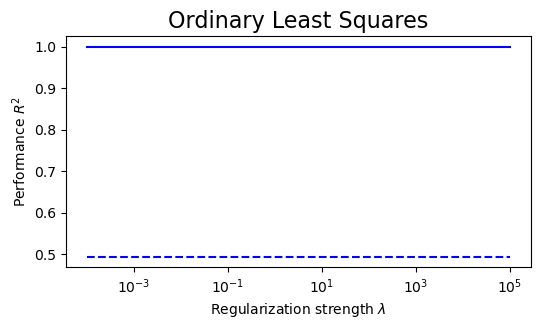

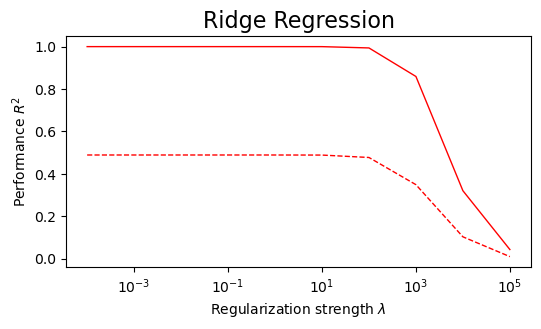

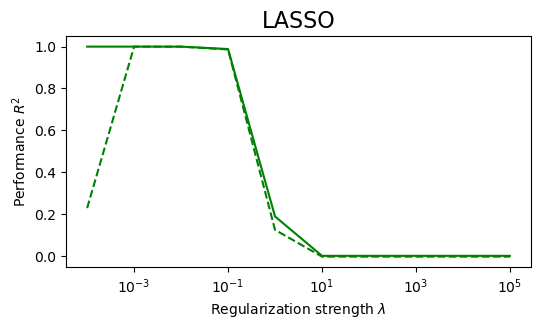

In [63]:
# Plot our performance on both the training and test data
plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_ols, "b", label="Train (OLS)")
plt.semilogx(lambdas, test_error_ols, "--b", label="Test (OLS)")
plt.title("Ordinary Least Squares", fontsize=16)
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Performance $R^2$")


plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_l2, "r", label="Train (Ridge)", linewidth=1)
plt.semilogx(lambdas, test_error_l2, "--r", label="Test (Ridge)", linewidth=1)
plt.title("Ridge Regression", fontsize=16)
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Performance $R^2$")

plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_l1, "g", label="Train (LASSO)")
plt.semilogx(lambdas, test_error_l1, "--g", label="Test (LASSO)")
plt.title("LASSO", fontsize=16)
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Performance $R^2$")


## Understanding our result

It looks like our coupling matrix is pretty sparse, and that the non-zero entries are concentrated along the off diagonal. This means that our Hamiltonian likely corresponds to the nearest-neighbor Ising model

$$
\mathcal{H}(\mathbf{s}^{(i)})=-J\sum_{j=1}^L s_{j}^{(i)}\, s_{j+1}^{(i)}
$$


+ When $\lambda\to 0$ and $\lambda\to\infty$, all three models overfit the data, as can be seen from the deviation of the test errors from unity (dashed lines), while the training curves stay at unity. 

+ While the ordinary least-squares and Ridge regression test curves are monotonic, the LASSO test curve is not -- suggesting the optimal LASSO regularization parameter is $\lambda\approx 10^{-2}$. At this sweet spot, the Ising interaction weights ${\bf J}$ contain only nearest-neighbor terms (as did the model the data was generated from).

+ Notice how Lasso was able to correctly identify that the coupling matrix is non-symmetric, while OLS and Ridge both favored finding symmetric matrices. 

# Hyperparameter tuning

We can imagine that an even more general model would have both regularizers, each with different strengths
$$
\mathcal{L}_{total} = \mathcal{L}_{least-squares} + \lambda_1 \mathcal{L}_{lasso} + \lambda_2 \mathcal{L}_{ridge}
$$
This loss function is sometimes referred to as least-squares with an ElasticNet penalty.


## Why not always use regularizers
+ The issue: we have two arbitrary factors, $\lambda_1$ and $\lambda_2$, which determine how important the L1 and L2 penalties are relative to the primary fitting. These change the available solution space and thus model class
+ These are not "fit" during training like ordinary parameters; rather they are specified beforehand, perhaps with a bit of intuition or domain knowledge, These therefore represent *hyperparameters* of the model
+ Generally speaking, any "choices" we make---amount of data, model type, model parameters, neural network depth, etc are all hyperparameters. How do we choose these in a principled manner?
+ A major question in machine learning: **How do we choose the best hyperparameters for a model?**



## Validation set
+ Hold out some data just for hyperparameter tuning, separate from the test set
+ Don't validate on test, that leads to data leakage and thus overfitting

Best lambda on validation set 0.0005336699231206307


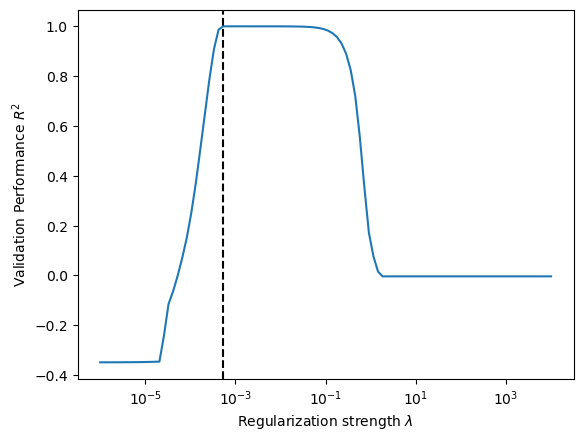

In [73]:
from sklearn import linear_model

# define train, validation and test data sets
X_train, X_val, X_test = X_all[:400], X_all[400 : 600], X_all[600 : 800]
y_train, y_val, y_test = y_all[:400], y_all[400 : 600], y_all[600 : 800]

# the hyperparameter values to check
lambdas = np.logspace(-6, 4, 100)

all_validation_losses = list()

for lam in lambdas:
    model_l1 = linear_model.Lasso(alpha=lam)
    model_l1.fit(X_train, y_train)
    validation_loss = model_l1.score(X_val, y_val)
    all_validation_losses.append(validation_loss)

best_lambda = lambdas[np.argmax(all_validation_losses)]

plt.semilogx(lambdas, all_validation_losses, label="Validation")
plt.axvline(best_lambda, color='k', linestyle='--', label="Best lambda")
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Validation Performance $R^2$")

print("Best lambda on validation set", best_lambda)

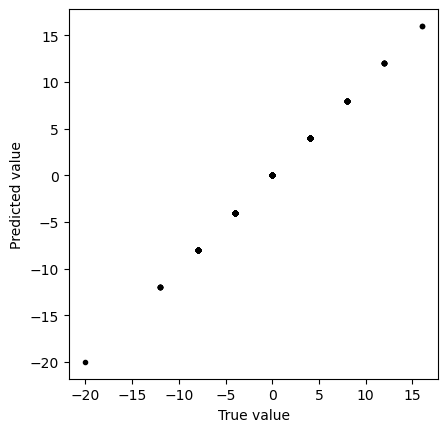

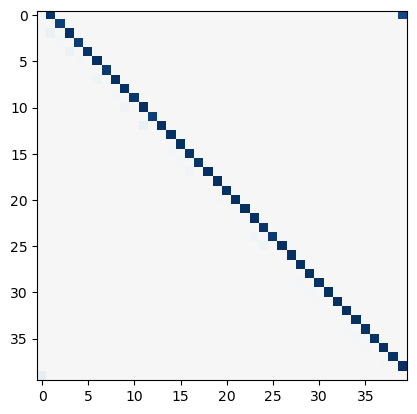

In [74]:
# fit best model 
model_l1 = linear_model.Lasso(alpha=best_lambda)
model_l1.fit(X_train, y_train)

y_test_predict = model_l1.predict(X_test)

plt.figure()
plt.plot(y_test, y_test_predict, ".k")
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.gca().set_aspect(1)


# plot Ising interaction J
J_lasso = np.array(model_l1.coef_).reshape((L, L))
plt.figure()
plt.imshow(J_lasso,  cmap="RdBu_r", vmin=-1, vmax=1)
plt.gca().set_aspect(1)

## Cross-validation

+ We repeatedly split-up the train into multiple sub-splits for training and validation
+ For example, if we have 100 train points, we can create five 80:20 "splits", and average the best hyperparameter across the splits
+ If we perform $k$ subsplits, we refer to our procedure as k-fold cross-validation
+ More elaborate splitting methods (random Monte Carlo, importance weighted, etc)

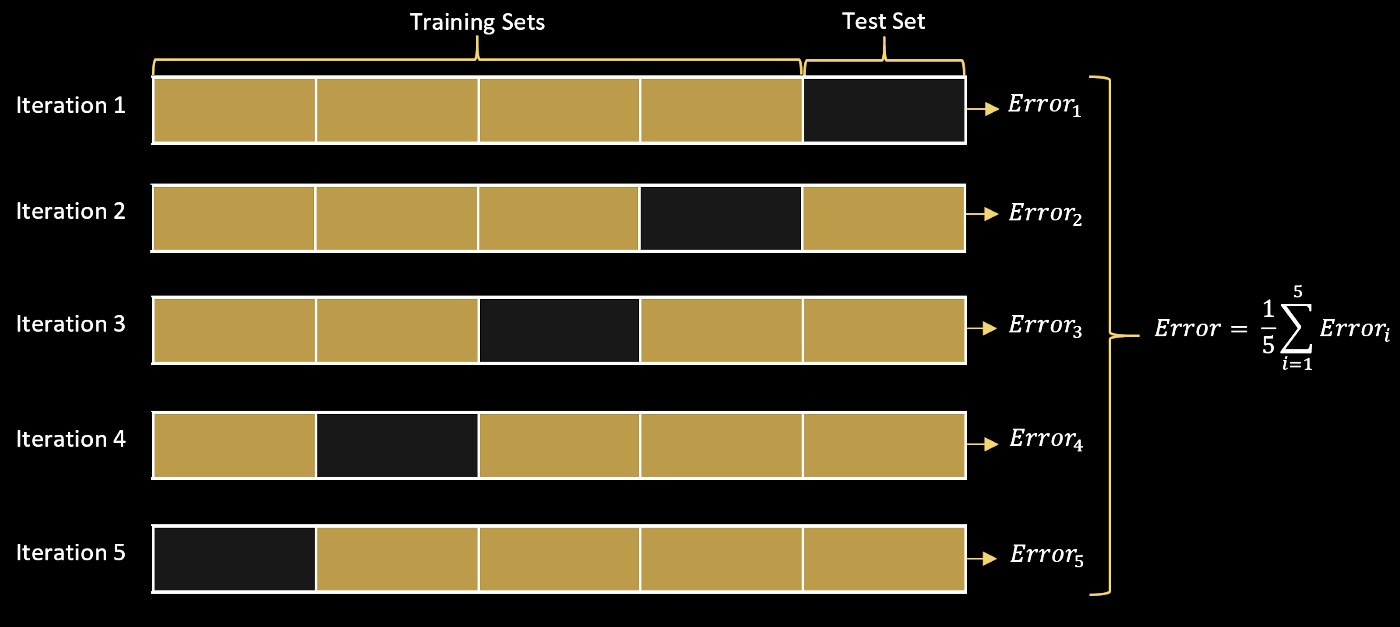

In [4]:
Image("../resources/cross_val.png", width=1000)
# https://towardsdatascience.com/cross-validation-k-fold-vs-monte-carlo-e54df2fc179b

Best lambda on validation set 0.005623413251903491


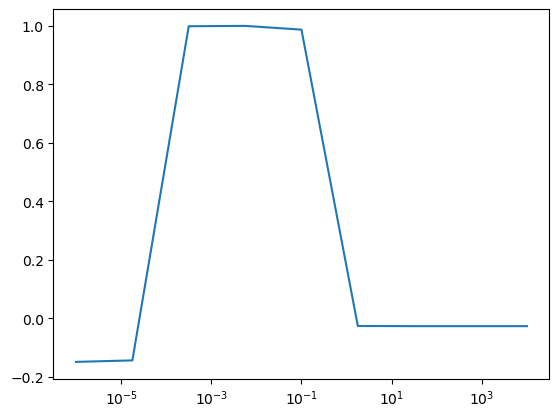

In [64]:
## Cross validation

from sklearn import linear_model

# define train, validation and test data sets
X_train, X_test = X_all[:600], X_all[600 : 800]
y_train, y_test = y_all[:600], y_all[600 : 800]

# the hyperparameter values to check
lambdas = np.logspace(-6, 4, 9)

all_validation_losses = list()

for lam in lambdas:

    all_val_loss_lam = list()

    for k in range(5):

        # Create the training and validation subsets from the training data
        X_train_k = np.concatenate([X_train[:k*100], X_train[(k+1)*100:]])
        y_train_k = np.concatenate([y_train[:k*100], y_train[(k+1)*100:]])
        X_val_k = X_train[k*100:(k+1)*100]
        y_val_k = y_train[k*100:(k+1)*100]


        model_l1 = linear_model.Lasso(alpha=lam)
        model_l1.fit(X_train_k, y_train_k)
        validation_loss = model_l1.score(X_val_k, y_val_k)
        all_val_loss_lam.append(validation_loss)

    all_validation_losses.append(np.mean(all_val_loss_lam))

best_lambda = lambdas[np.argmax(all_validation_losses)]
plt.figure()
plt.semilogx(lambdas, all_validation_losses, label="Validation")
print("Best lambda on validation set", best_lambda)

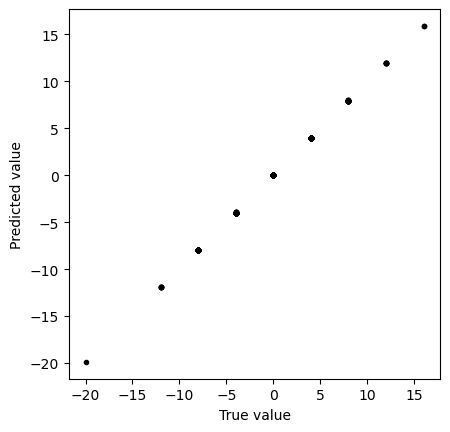

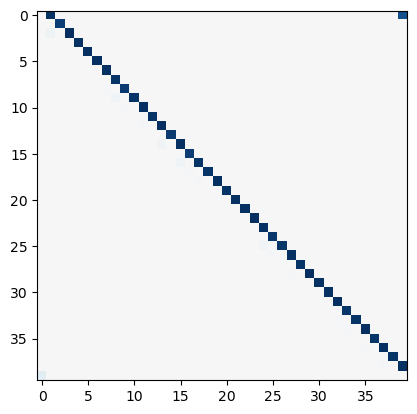

In [69]:
# fit best model 
model_l1 = linear_model.Lasso(alpha=best_lambda)
model_l1.fit(X_train, y_train)

y_test_predict = model_l1.predict(X_test)

plt.figure()
plt.plot(y_test, y_test_predict, ".k")
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.gca().set_aspect(1)


# plot Ising interaction J
J_lasso = np.array(model_l1.coef_).reshape((L, L))
plt.figure()
plt.imshow(J_lasso,  cmap="RdBu_r", vmin=-1, vmax=1)
plt.gca().set_aspect(1)

## How many free parameters are in our model?

Linear regression:

$$
y_i = \mathbf{A} \mathbf{X}_i
$$

+ In our Ising example, the fitting parameters $\mathbf{A}$ corresponded to our coupling matrix $\mathbf{J}$
+ $\mathbf{X}_i$ were our spin product microstates, and $y_i$ was their energies
+ $\mathbf{J} \in \mathbb{R}^{40 \times 40}$ because our inputs (microstates) are on an $L = 40$ lattice, and so we had $1600$ free parameters


## What if we wanted to increase our model complexity?

### Idea: 

$$
y_i = \mathbf{B} \mathbf{C} \mathbf{X}_i
$$

where $\mathbf{B} \in \mathbb{R}^{40 \times p}$ and $\mathbf{C} \in \mathbb{R}^{p \times 40}$, with $p$ being a hyperparameter that controls the complexity of the model. This "hidden" or "latent" dimensionality allows us to have a more complex model.

However, the problem is that $\mathbf{B} \mathbf{C} \equiv \mathbf{A}\in \mathbb{R}^{40 \times 40}$, so we don't gain any expressivity

### Solution:

$$
y_i = \mathbf{B} \sigma(\mathbf{C} \mathbf{X}_i)
$$

where $\sigma(.)$ is an elementwise nonlinear function, like $\tanh(.)$. Now the model doesn't collapse, so we have $2 \times 40 \times p$ free parameters.

This is a one-layer neural network, with a $p$ unit "hidden" layer. We can always go wider or deeper to further increase the model complexity.

# Appendix

Simulate the Ising model with nearest-neighbor interactions with periodic boundary conditions. The energy of a spin configuration $\boldsymbol{\sigma} = \{\sigma_1,\dots,\sigma_N\}$ is given by

$$
E[\boldsymbol{\sigma}] = -J\sum_{\langle i,j\rangle} \sigma_i \sigma_j
$$

where the sum is over all pairs of nearest neighbors on a $L\times L$ square lattice, and $J$ is the coupling constant. The magnetization is given by

$$
M[\boldsymbol{\sigma}] = \sum_{i=1}^N \sigma_i
$$

In [25]:
class IsingModel:
    """
    The Ising model with ferromagnetic interactions that encourage nearest neighbors
    to align
    """
    def __init__(self, L, random_state=None):
        self.L = L
        self.random_state = random_state
        
        self.J = np.diag(-np.ones(L - 1), 1)
        self.J [-1, 0] = -1.0 # periodic boundary conditions

    def sample(self, n_samples=1):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        return np.random.choice([-1, 1], size=(n_samples, self.L))

    def energy(self, state):
        return np.einsum("...i,ij,...j->...", states, self.J, states)

model_experiment = IsingModel(40, random_state=0)

# create 10000 random Ising states
states = model_experiment.sample(n_samples=10000)


# calculate Ising energies
energies = model_experiment.energy(states)

print("Input data has shape: ", states.shape)
print("Labels have shape: ", energies.shape)


## Save data
# states.dump("../resources/spin_microstates.npy")
# energies.dump("../resources/spin_energies.npy")

Input data has shape:  (10000, 40)
Labels have shape:  (10000,)


## Choosing the right model for the problem

First of all, we have to decide on a model class (possible Hamiltonians) we use to fit the data. In the absence of any prior knowledge, one sensible choice is the all-to-all Ising model

$$
H_\mathrm{model}[\boldsymbol{S}^i] = - \sum_{j=1}^L \sum_{k=1}^L J_{j,k}S_{j}^iS_{k}^i.
$$
Notice that this model is uniquely defined by the non-local coupling strengths $J_{jk}$ which we want to learn. Importantly, this model is linear in ${\mathbf J}$ which makes it possible to use linear regression to fit the values of $\mathbf{J}$.

However, our regression inputs are vector microstates $\mathbf{X}$, while our outputs are scalar energies $H$. However, our Hamiltonian is a function of spin-spin interactions, and so, in order to apply linear regression, we would like to recast this model in the form
$$
H_\mathrm{model}^i \equiv \mathbf{X}^i \cdot \mathbf{J},
$$

where the vectors $\mathbf{X}^i$ represent all two-body interactions $\{S_{j}^iS_{k}^i \}_{j,k=1}^L$, and the index $i$ runs over the samples in the data set. To make the analogy complete, we can also represent the dot product by a single index $p = \{j,k\}$, i.e. $\mathbf{X}^i \cdot \mathbf{J}=X^i_pJ_p$. Note that the regression model does not include the minus sign, so we expect to learn negative $J$'s.

#### Our inductive bias

If we had known nothing at all about the generator of our data, we might have just passed the input spin vectors $\mathbf{S}$ as the inputs to our model. However, in this case we have prior knowledge that our Hamiltonian acts on nearest-neighbor interactions. Rather than leaving it to our model to figure this out, we can encode our "inductive bias" by feeding in training data that already has the form of a neighbor matrix

